<a href="https://colab.research.google.com/github/thekishanpatel/FastAi/blob/master/CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation with the Camvid Dataset**
*U-Net Architecture*  
FastAi


# **Impoort Libraries**

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.


# **Get The Data**

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

## ***Prepare DataBunch***

In [0]:
path_labels = path/'labels'
path_images = path/'images'

In [8]:
im_names = get_image_files(path_images)
lbl_names = get_image_files(path_labels)
im_names[:5]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_008820.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07770.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_00960.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009930.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01770.png')]

In [9]:
lbl_names[:5]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00750_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05760_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008640_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_008520_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03960_P.png')]

In [0]:
# A function to get the pixel-labels--removing the '_P'
get_label = lambda x: path_labels/f'{x.stem}_P{x.suffix}'

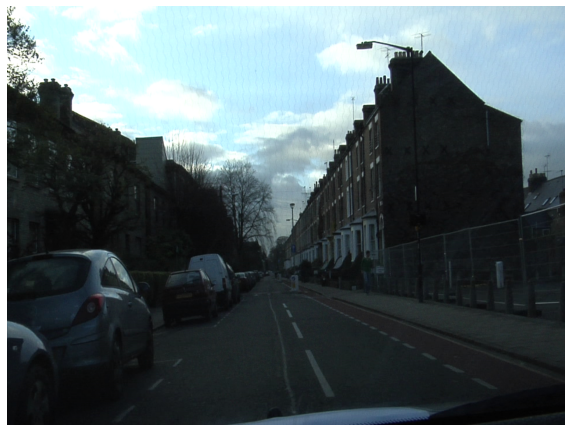

In [10]:
image = open_image(im_names[10])
image.show(figsize=(10,10))

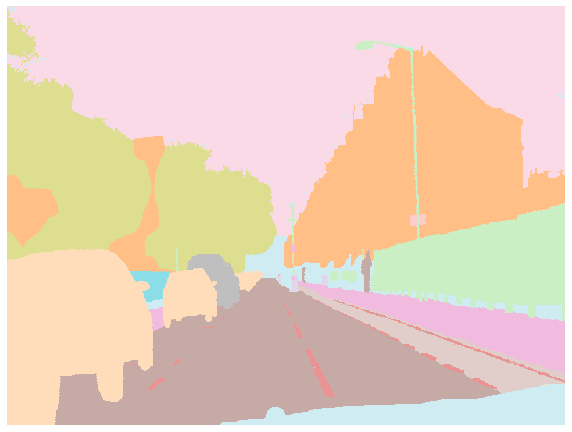

In [24]:
mask = open_mask(get_label(im_names[10]))
mask.show(figsize=(10,10))

In [15]:
mask_size = np.array(mask.shape[1:]) # Checking the Array Shape
mask_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [30, 30, 21,  ..., 21, 21, 21],
          ...,
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30],
          [ 5,  5,  5,  ..., 30, 30, 30]]]))

In [16]:
label_ids = np.loadtxt(path/'codes.txt', dtype = str) # What the Pixel Labels represent
label_ids

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### *Some Observation*
Note that the object at index = 5 in the array is car, also note that 5 is in the bottom-left corner of the 'mask.data,' now look at the original image and note that there is a car in the bottom-left corner of the image.

In [20]:
size = mask_size // 2
free = gpu_mem_get_free_no_cache() # Batch Size depends on GPU RAM

if free > 8200: bs = 8
else: bs = 4
print("{} MB of GPU RAM available. Setting batch-size to {}".format(free, bs))

16270 MB of GPU RAM available. Setting batch-size to 8


In [0]:
source = (SegmentationItemList.from_folder(path_images)
          .split_by_fname_file('../valid.txt')
          .label_from_func(get_label, classes = label_ids))

In [0]:
data = (source.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

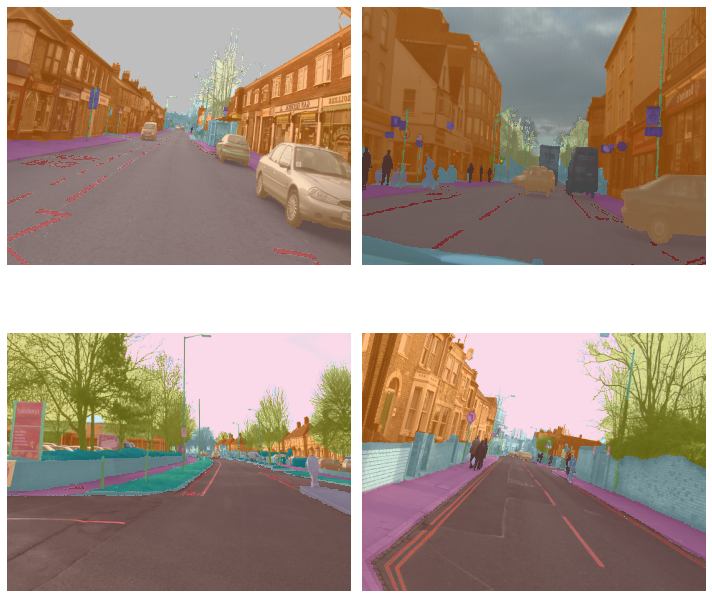

In [23]:
data.show_batch(2, figsize=(10,10))